In [6]:
import pandas as pd

data = pd.read_csv('../../data/processed/import_declarations_intermax_daily.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Abgabe
0,2017-01-02,439.79
1,2017-01-03,2107.94
2,2017-01-04,215.37
3,2017-01-05,0.00
4,2017-01-06,0.00


In [7]:
X = data.drop(columns='Abgabe')
y = data['Abgabe']

X, y

(           Date
 0    2017-01-02
 1    2017-01-03
 2    2017-01-04
 3    2017-01-05
 4    2017-01-06
 ...         ...
 1040 2019-11-08
 1041 2019-11-09
 1042 2019-11-10
 1043 2019-11-11
 1044 2019-11-12
 
 [1045 rows x 1 columns],
 0        439.79
 1       2107.94
 2        215.37
 3          0.00
 4          0.00
          ...   
 1040    1265.71
 1041       0.00
 1042       0.00
 1043       0.00
 1044     369.00
 Name: Abgabe, Length: 1045, dtype: float64)

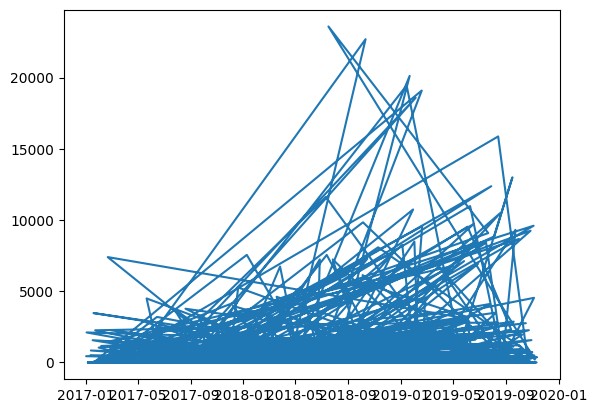

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.plot(X_train, y_train)

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)


y_pred = gb_model.predict(X_test)

# Step 4: Plot the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Abgabe', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Abgabe', color='red')
plt.title('Abgabe Prediction with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel('Abgabe')
plt.legend()
plt.show()